In [15]:
import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
from datetime import datetime
# Make `src` dir can be imported
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))  # /aicup-predict-energy-generation
sys.path.append(project_root_path)  


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [2]:
df_sunlight = pd.read_csv('../data/processed_data/sunlight_simulation_data.csv')
df_sunlight['datetime'] = pd.to_datetime(df_sunlight['datetime'])

In [3]:
df_sunlight.head()

,datetime,windspeed,pressure,temperature,humidity,sunlight,power,device
0,2024-03-02 06:06:47,0.0,1020.13,14.18,94.37,22.50,0.0,L10
1,2024-03-02 06:07:47,0.0,1020.10,14.19,94.27,28.33,0.0,L10
2,2024-03-02 06:08:47,0.0,1020.07,14.19,94.35,34.17,0.0,L10
3,2024-03-02 06:09:47,0.0,1020.07,14.19,94.42,35.83,0.0,L10
4,2024-03-02 06:10:47,0.0,1020.04,14.20,94.46,37.50,0.0,L10


In [28]:
df_sunlight['date'] = pd.to_datetime(df_sunlight['datetime'].dt.date)
df_sunlight['hour'] = df_sunlight['datetime'].dt.hour

In [29]:
hour_for_sub = [10, 11, 12]
df_sunlight['new_sunlight'] = df_sunlight.apply(lambda x: x['sunlight'] if x['hour'] not in hour_for_sub else None, axis=1)
df_sunlight[df_sunlight['hour'].isin(hour_for_sub)].new_sunlight.value_counts()

Series([], Name: count, dtype: int64)

In [44]:
# for date in df_sunlight.date.unique().tolist():
#     df_date = df_sunlight[df_sunlight['date'] == date].set_index('datetime')
df_date = df_sunlight[df_sunlight['date'] == pd.Timestamp(2024, 7, 5)].set_index('datetime')

In [45]:
df_date.set_index(pd.date_range(start=df_date.index[0], end=df_date.index[-1], freq='min'), inplace=True)

In [46]:
# df_date.new_sunlight.to_csv('../data/processed_data/new_sunlight_test.csv')

In [47]:
one = pd.Timedelta(minutes=1)
firstTS = df_date[df_date['hour'] < 10].new_sunlight.copy()
secondTS = df_date[df_date['hour'] > 12].new_sunlight.copy()

firstTSr = firstTS[::-1].copy()
secondTSr = secondTS[::-1].copy()

indexr = pd.date_range(start=firstTS.index[0], end=secondTS.index[-1], freq='min')
firstTSr.index = indexr[-len(firstTSr):]
secondTSr.index = indexr[:len(secondTSr)]

In [48]:
secondTS

2024-07-05 13:00:27    5174.17
2024-07-05 13:01:27    5338.33
2024-07-05 13:02:27    5496.67
2024-07-05 13:03:27    5528.33
2024-07-05 13:04:27    5495.00
                        ...   
2024-07-05 18:54:27      46.67
2024-07-05 18:55:27      38.33
2024-07-05 18:56:27      31.67
2024-07-05 18:57:27      25.83
2024-07-05 18:58:27      20.83
Freq: min, Name: new_sunlight, Length: 359, dtype: float64

In [49]:
seasonal_periods = 70
#FORWARD    
es = ExponentialSmoothing(firstTS, seasonal=None, trend='add').fit()
forwardPrediction = es.predict(start=firstTS.index[-1]+one, end=secondTS.index[0]-one)

#BACKWARD
es = ExponentialSmoothing(secondTSr, seasonal=None, trend='add').fit()
backwardPrediction = es.predict(start=secondTSr.index[-1]+one, end=firstTSr.index[0]-one)

l = len(forwardPrediction)
interpolation = pd.Series([(backwardPrediction[i] * i + forwardPrediction[i] * (l -i) )/ l for i in range(l)], index=forwardPrediction.index.copy())

C:\Users\sean.chang\AppData\Local\Temp\ipykernel_9892\3128998962.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  interpolation = pd.Series([(backwardPrediction[i] * i + forwardPrediction[i] * (l -i) )/ l for i in range(l)], index=forwardPrediction.index.copy())


In [50]:
backwardPrediction

2024-07-05 10:58:27     5009.482019
2024-07-05 10:59:27     4844.756986
2024-07-05 11:00:27     4680.031953
2024-07-05 11:01:27     4515.306920
2024-07-05 11:02:27     4350.581888
                           ...     
2024-07-05 13:53:27   -23817.398708
2024-07-05 13:54:27   -23982.123741
2024-07-05 13:55:27   -24146.848774
2024-07-05 13:56:27   -24311.573806
2024-07-05 13:57:27   -24476.298839
Freq: min, Length: 180, dtype: float64

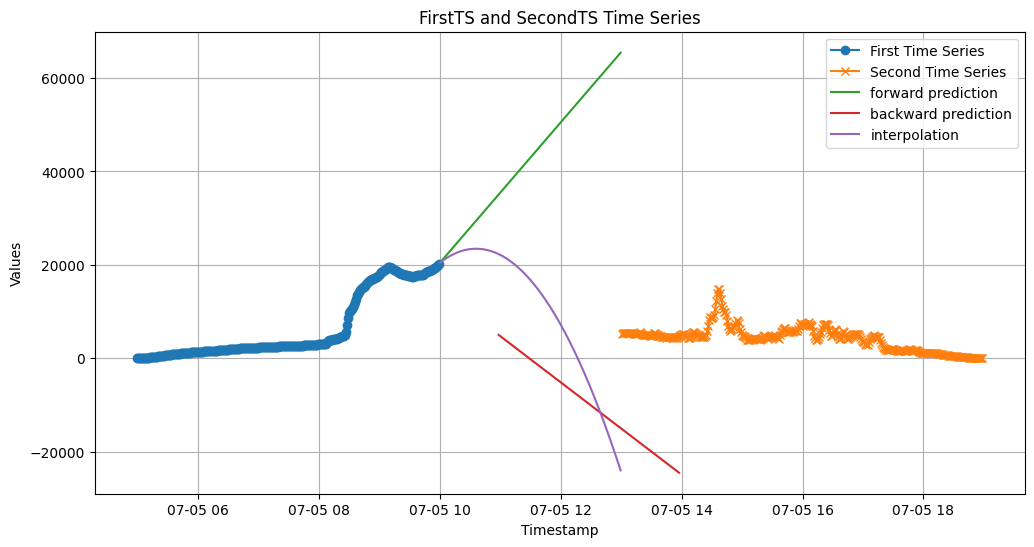

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(firstTS, label='First Time Series', marker='o')
plt.plot(secondTS, label='Second Time Series', marker='x')
plt.plot(forwardPrediction, label='forward prediction')
plt.plot(backwardPrediction, label='backward prediction')
plt.plot(interpolation, label='interpolation')
plt.title('FirstTS and SecondTS Time Series')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [52]:
df_test = df_date[['new_sunlight']]

In [53]:
df_test['new_sunlight_interpolated'] = df_test['new_sunlight'].interpolate(method='spline', order=4)

C:\Users\sean.chang\AppData\Local\Temp\ipykernel_9892\965692540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['new_sunlight_interpolated'] = df_test['new_sunlight'].interpolate(method='spline', order=4)


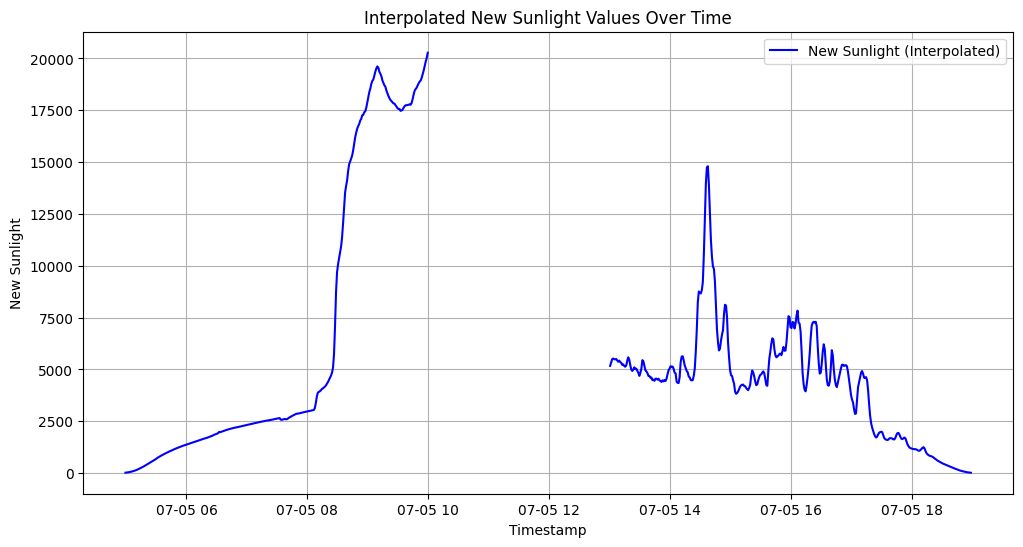

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test['new_sunlight'], label='New Sunlight (Interpolated)', color='blue')
plt.title('Interpolated New Sunlight Values Over Time')
plt.xlabel('Timestamp')
plt.ylabel('New Sunlight')
plt.legend()
plt.grid()
plt.show()

In [55]:
test=2